In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-05-31 18:05:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 34.64.4.48, 34.64.4.80, 34.64.4.112, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|34.64.4.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2021-05-31 18:05:47 (51.7 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [4]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
num_epochs = 30
history = model.fit(
    training_padded, 
    training_labels, 
    epochs=num_epochs, 
    validation_data=(testing_padded, testing_labels), verbose=2
)

Epoch 1/30
625/625 - 2s - loss: 0.6654 - accuracy: 0.5849 - val_loss: 0.5862 - val_accuracy: 0.6779
Epoch 2/30
625/625 - 1s - loss: 0.4320 - accuracy: 0.8289 - val_loss: 0.3889 - val_accuracy: 0.8348
Epoch 3/30
625/625 - 1s - loss: 0.3105 - accuracy: 0.8726 - val_loss: 0.3533 - val_accuracy: 0.8521
Epoch 4/30
625/625 - 1s - loss: 0.2579 - accuracy: 0.8985 - val_loss: 0.3429 - val_accuracy: 0.8587
Epoch 5/30
625/625 - 1s - loss: 0.2227 - accuracy: 0.9138 - val_loss: 0.3451 - val_accuracy: 0.8557
Epoch 6/30
625/625 - 1s - loss: 0.1949 - accuracy: 0.9262 - val_loss: 0.3541 - val_accuracy: 0.8547
Epoch 7/30
625/625 - 1s - loss: 0.1729 - accuracy: 0.9351 - val_loss: 0.3681 - val_accuracy: 0.8520
Epoch 8/30
625/625 - 1s - loss: 0.1536 - accuracy: 0.9440 - val_loss: 0.3818 - val_accuracy: 0.8539
Epoch 9/30
625/625 - 1s - loss: 0.1381 - accuracy: 0.9510 - val_loss: 0.4153 - val_accuracy: 0.8429
Epoch 10/30
625/625 - 1s - loss: 0.1247 - accuracy: 0.9557 - val_loss: 0.4264 - val_accuracy: 0.8477

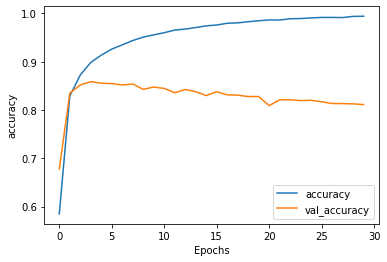

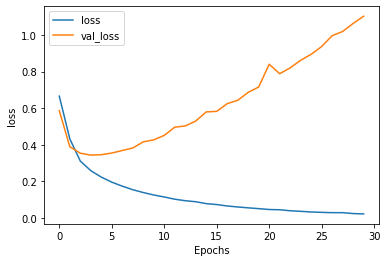

In [11]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(training_sentences[2])
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) 

(10000, 16)


In [18]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

In [19]:
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

In [20]:
sentence = ["granny starting to fear spiders in the garden might be real", 
            "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(model.predict(padded))

[[9.8729002e-01]
 [3.1324234e-05]]
